場所をみなとみらいに限定し、ホテル名、値段、最寄り駅からホテルまでの所要時間をスクレイピングした。
データを可視化し、その相関関係を調べる。

In [5]:
# 必要なモジュールをインポートする
import sqlite3
import requests
from bs4 import BeautifulSoup
import re
import time
import chardet  # エンコーディング検出用

# データベースの初期化またはアップデート
def init_db():
    conn = sqlite3.connect("hotels.db")  # データベース名前はhotels.db
    cursor = conn.cursor()
    
    # テーブルが存在しない場合は作成
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS hotel_info (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            hotel_name TEXT,
            price TEXT,
            walking_time TEXT
        )
    """)
    
    # `walking_time` カラムが存在しない場合は追加
    try:
        cursor.execute("ALTER TABLE hotel_info ADD COLUMN walking_time TEXT")
    except sqlite3.OperationalError:
        # カラムが既に存在する場合はエラーを無視
        pass

    conn.commit()  # データベースに変更を反映
    conn.close()  # データベースを閉じる

# データを挿入
def insert_data(hotel_name, price, walking_time):
    conn = sqlite3.connect("hotels.db")
    cursor = conn.cursor()
    cursor.execute("INSERT INTO hotel_info (hotel_name, price, walking_time) VALUES (?, ?, ?)", (hotel_name, price, walking_time))
    conn.commit()
    conn.close()

# 駅から徒歩時間を抽出する関数
def extract_walking_time(catch_phrase):
    match = re.search(r"徒歩(\d+)分", catch_phrase)
    if match:
        return f"{match.group(1)}分"
    else:
        return "情報なし"

# 指定したURLからスクレイピング
def scrape_url(url):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        # レスポンスのエンコーディングを自動検出
        detected_encoding = chardet.detect(response.content)["encoding"]

        # BeautifulSoupにエンコーディングを明示
        soup = BeautifulSoup(response.content, "html.parser", from_encoding=detected_encoding)
        hotel_items = soup.find_all("li", class_="p-yadoCassette p-searchResultItem")

        for item in hotel_items:
            try:
                # ホテル名
                hotel_name = item.find("h2", class_="p-searchResultItem__facilityName").text.strip()

                # 値段
                price = item.find("span", class_="p-searchResultItem__perPersonPrice").text.strip()

                # 徒歩時間をキャッチフレーズから抽出
                catch_phrase_tag = item.find("p", class_="p-searchResultItem__catchPhrase")
                if catch_phrase_tag:
                    catch_phrase = catch_phrase_tag.text.strip()
                    walking_time = extract_walking_time(catch_phrase)
                else:
                    walking_time = "情報なし"

                print(f"ホテル名: {hotel_name}, 値段: {price}, 徒歩時間: {walking_time}")

                # データベースに挿入
                insert_data(hotel_name, price, walking_time)

                # サーバー負荷を避けるためのスリープ
                time.sleep(1)
            except AttributeError:
                # 必要な要素が見つからない場合にスキップ
                continue
    else:
        print(f"Failed to fetch the page. Status code: {response.status_code}")

# メイン処理
if __name__ == "__main__":
    init_db()  # データベースの初期化またはアップデート

    # スクレイピングするURLリスト
    urls = [
        "https://www.jalan.net/uw/uwp2011/uww2011search.do?actionId=G&keyword=%82%DD%82%C8%82%C6%82%DD%82%E7%82%A2&dateUndecided=1&stayYear=2025&stayMonth=01&stayDay=14&adultNum=1&minPrice=0&maxPrice=999999&distCd=06&rootCd=7701&dispStartIndex=0&activeSort=0&screenId=UWW2011",
        "https://www.jalan.net/uw/uwp2011/uww2011search.do?actionId=G&keyword=%82%DD%82%C8%82%C6%82%DD%82%E7%82%A2&dateUndecided=1&stayYear=2025&stayMonth=01&stayDay=14&adultNum=1&minPrice=0&maxPrice=999999&distCd=06&rootCd=7701&dispStartIndex=30&activeSort=0&screenId=UWW2011",
        "https://www.jalan.net/uw/uwp2011/uww2011search.do?actionId=G&keyword=%82%DD%82%C8%82%C6%82%DD%82%E7%82%A2&dateUndecided=1&stayYear=2025&stayMonth=01&stayDay=14&adultNum=1&minPrice=0&maxPrice=999999&distCd=06&rootCd=7701&dispStartIndex=60&activeSort=0&screenId=UWW2011",
        "https://www.jalan.net/uw/uwp2011/uww2011search.do?actionId=G&keyword=%82%DD%82%C8%82%C6%82%DD%82%E7%82%A2&dateUndecided=1&stayYear=2025&stayMonth=01&stayDay=14&adultNum=1&minPrice=0&maxPrice=999999&distCd=06&rootCd=7701&dispStartIndex=90&activeSort=0&screenId=UWW2011"
    ]

    # 各URLを順にスクレイピング
    for url in urls:
        scrape_url(url)


ホテル名: ザ・スクエアホテル横浜みなとみらい, 値段: 10,800円, 徒歩時間: 情報なし
ホテル名: 横浜みなとみらい　万葉倶楽部, 値段: 9,460円, 徒歩時間: 情報なし
ホテル名: 【ナビオス横浜】みなとみらい×赤レンガ☆360度極上夜景☆, 値段: 8,170円, 徒歩時間: 3分
ホテル名: 三井ガーデンホテル横浜みなとみらいプレミア, 値段: 26,900円, 徒歩時間: 情報なし
ホテル名: 京急EXホテルみなとみらい横浜（横浜シンフォステージ内）, 値段: 12,600円, 徒歩時間: 情報なし
ホテル名: ゲストハウス ＦＵＴＡＲＥＮＯ～横浜野毛みなとみらい～, 値段: 7,000円, 徒歩時間: 情報なし
ホテル名: ホテルセントラル横浜, 値段: 37,000円, 徒歩時間: 情報なし
ホテル名: ホテルリブマックス横浜元町駅前, 値段: 7,012円, 徒歩時間: 情報なし
ホテル名: ファーイーストビレッジホテル横浜, 値段: 10,710円, 徒歩時間: 5分
ホテル名: フレックステイイン桜木町, 値段: 6,990円, 徒歩時間: 5分
ホテル名: 横浜東急ＲＥＩホテル, 値段: 11,200円, 徒歩時間: 情報なし
ホテル名: ホテルマイステイズ横浜, 値段: 5,410円, 徒歩時間: 情報なし
ホテル名: 横浜桜木町ワシントンホテル, 値段: 10,400円, 徒歩時間: 1分
ホテル名: ホテルマイステイズ横浜関内, 値段: 6,090円, 徒歩時間: 1分
ホテル名: アパホテル＆リゾート〈横浜ベイタワー〉, 値段: 13,500円, 徒歩時間: 情報なし
ホテル名: ダイワロイネットホテル横浜公園, 値段: 9,700円, 徒歩時間: 情報なし
ホテル名: リッチモンドホテル横浜馬車道(2023年7月リニューアルオープン), 値段: 8,500円, 徒歩時間: 情報なし
ホテル名: インターコンチネンタル横浜Ｐｉｅｒ ８, 値段: 83,000円, 徒歩時間: 情報なし
ホテル名: 相鉄フレッサイン横浜桜木町, 値段: 8,400円, 徒歩時間: 情報なし
ホテル名: ザ・ゲートホテル横浜 by HULIC（2025年2月26日開業）, 値段: 26,835円, 徒歩時間: 情報なし
ホテル名: 新横浜グレイ

In [6]:
#dbに格納できているか確認する
# データベースに接続
conn = sqlite3.connect('hotels.db')

# カーソルを作成
cur = conn.cursor()

# SQLコマンドを実行
cur.execute("SELECT * FROM hotel_info")

# 結果を取得して表示
results = cur.fetchall()
for row in results:
    print(row)

# 接続を閉じる
conn.close()

(1, 'ザ・スクエアホテル横浜みなとみらい', '10,800円', '情報なし')
(2, '横浜みなとみらい\u3000万葉倶楽部', '9,460円', '情報なし')
(3, '【ナビオス横浜】みなとみらい×赤レンガ☆360度極上夜景☆', '8,170円', '3分')
(4, '三井ガーデンホテル横浜みなとみらいプレミア', '26,900円', '情報なし')
(5, '京急EXホテルみなとみらい横浜（横浜シンフォステージ内）', '12,600円', '情報なし')
(6, 'ゲストハウス ＦＵＴＡＲＥＮＯ～横浜野毛みなとみらい～', '7,000円', '情報なし')
(7, 'ホテルセントラル横浜', '37,000円', '情報なし')
(8, 'ホテルリブマックス横浜元町駅前', '7,012円', '情報なし')
(9, 'ファーイーストビレッジホテル横浜', '10,710円', '5分')
(10, 'フレックステイイン桜木町', '6,990円', '5分')
(11, '横浜東急ＲＥＩホテル', '11,200円', '情報なし')
(12, 'ホテルマイステイズ横浜', '5,410円', '情報なし')
(13, '横浜桜木町ワシントンホテル', '10,400円', '1分')
(14, 'ホテルマイステイズ横浜関内', '6,090円', '1分')
(15, 'アパホテル＆リゾート〈横浜ベイタワー〉', '13,500円', '情報なし')
(16, 'ダイワロイネットホテル横浜公園', '9,700円', '情報なし')
(17, 'リッチモンドホテル横浜馬車道(2023年7月リニューアルオープン)', '8,500円', '情報なし')
(18, 'インターコンチネンタル横浜Ｐｉｅｒ ８', '83,000円', '情報なし')
(19, '相鉄フレッサイン横浜桜木町', '8,400円', '情報なし')
(20, 'ザ・ゲートホテル横浜 by HULIC（2025年2月26日開業）', '26,835円', '情報なし')
(21, '新横浜グレイスホテル', '11,500円', '1分')
(22, '横浜ベイホテル東急', '21,600円', '情報なし')
(23, 'ホテルニューグランド', '27,

In [7]:
import pandas as pd
import re

class DatabaseAnalyzer:
    def __init__(self, dbname):
        self.dbname = dbname

    def get_data(self, query):
        # データベースに接続
        conn = sqlite3.connect(self.dbname)

        # SQLクエリを発行してデータをPandasのデータフレームに読み込む
        df = pd.read_sql_query(query, conn)

        # 接続を閉じる
        conn.close()

        return df

    def clean_price_column(self, df):
        #正規表現を用いて徒歩時間から数値のみを抽出
        df['walking_time'] = df['walking_time'].apply(lambda x: int(re.search(r'\d+', x).group()) if re.search(r'\d+', x) else None)
        # 正規表現を用いて価格列から数値のみを抽出
        df['price'] = df['price'].apply(lambda x: int(re.search(r'\d+', x.replace(',', '')).group()) if re.search(r'\d+', x) else None)
        return df

    def analyze_price(self, df):
        # クレンジングされたデータを使用して統計量を出力
        if df['price'].isnull().any():
            print("一部のデータに無効な価格情報が含まれていましたが、それらを除外して処理しました。")

        # 基本統計量を表示
        print(df['price'].describe())


# データベースアナライザーのインスタンスを作成
analyzer = DatabaseAnalyzer('hotels.db')

# データを取得
data = analyzer.get_data("SELECT * FROM hotel_info")

# 価格列をクレンジング
data = analyzer.clean_price_column(data)

# 価格データを分析
analyzer.analyze_price(data)


count       273.000000
mean      15147.344322
std       14127.077512
min        3300.000000
25%        7900.000000
50%       10000.000000
75%       17250.000000
max      101326.000000
Name: price, dtype: float64


In [8]:
#dfを定義する
df = data
# 価格帯を定義
bins = [0, 5000, 10000, 15000, 20000, 30000, 40000, 50000, float('inf')]
labels = ['0-5000', '5000-10000', '10000-15000', '15000-20000', '20000-30000', '30000-40000', '40000-50000', '50000+']

# 価格帯に基づいて新しい列を作成
df['price_range'] = pd.cut(df['price'], bins=bins, labels=labels)

# 価格帯ごとにホテル数を集計
print(df['price_range'].value_counts().sort_index())

price_range
0-5000          10
5000-10000     128
10000-15000     56
15000-20000     22
20000-30000     35
30000-40000     14
40000-50000      2
50000+           6
Name: count, dtype: int64


In [9]:
# 価格が高い順に並べ替える
df = df.sort_values('price', ascending=False)

# データフレームを表示
df

,id,hotel_name,price,walking_time,price_range
272,273,ザ・カハラ・ホテル＆リゾート 横浜,101326,NaN,50000+
92,93,ザ・カハラ・ホテル＆リゾート 横浜,101326,NaN,50000+
156,157,インターコンチネンタル横浜Ｐｉｅｒ ８,83000,NaN,50000+
197,198,インターコンチネンタル横浜Ｐｉｅｒ ８,83000,NaN,50000+
17,18,インターコンチネンタル横浜Ｐｉｅｒ ８,83000,NaN,50000+
...,...,...,...,...,...
170,171,俠俫俬俴俴倀俴倀丂俫俷俽俿俤俴丂乮僠儖儖丂儂僗僥儖),3600,NaN,0-5000
124,125,俠俫俬俴俴倀俴倀丂俫俷俽俿俤俴丂乮僠儖儖丂儂僗僥儖),3600,NaN,0-5000
211,212,ＣＨＩＬＬＵＬＵ ＨＯＳＴＥＬ （チルル ホステル),3600,NaN,0-5000
52,53,儓僐僴儅儂僗僥儖償傿儗僢僕椦夛娰,3300,NaN,0-5000


In [10]:
#価格が低い順に並べ変える
df = df.sort_values('price', ascending=True)

# データフレームを表示
df

,id,hotel_name,price,walking_time,price_range
232,233,ヨコハマホステルヴィレッジ林会館,3300,5.0,0-5000
52,53,儓僐僴儅儂僗僥儖償傿儗僢僕椦夛娰,3300,NaN,0-5000
124,125,俠俫俬俴俴倀俴倀丂俫俷俽俿俤俴丂乮僠儖儖丂儂僗僥儖),3600,NaN,0-5000
31,32,俠俫俬俴俴倀俴倀丂俫俷俽俿俤俴丂乮僠儖儖丂儂僗僥儖),3600,NaN,0-5000
211,212,ＣＨＩＬＬＵＬＵ ＨＯＳＴＥＬ （チルル ホステル),3600,NaN,0-5000
...,...,...,...,...,...
17,18,インターコンチネンタル横浜Ｐｉｅｒ ８,83000,NaN,50000+
197,198,インターコンチネンタル横浜Ｐｉｅｒ ８,83000,NaN,50000+
156,157,インターコンチネンタル横浜Ｐｉｅｒ ８,83000,NaN,50000+
92,93,ザ・カハラ・ホテル＆リゾート 横浜,101326,NaN,50000+


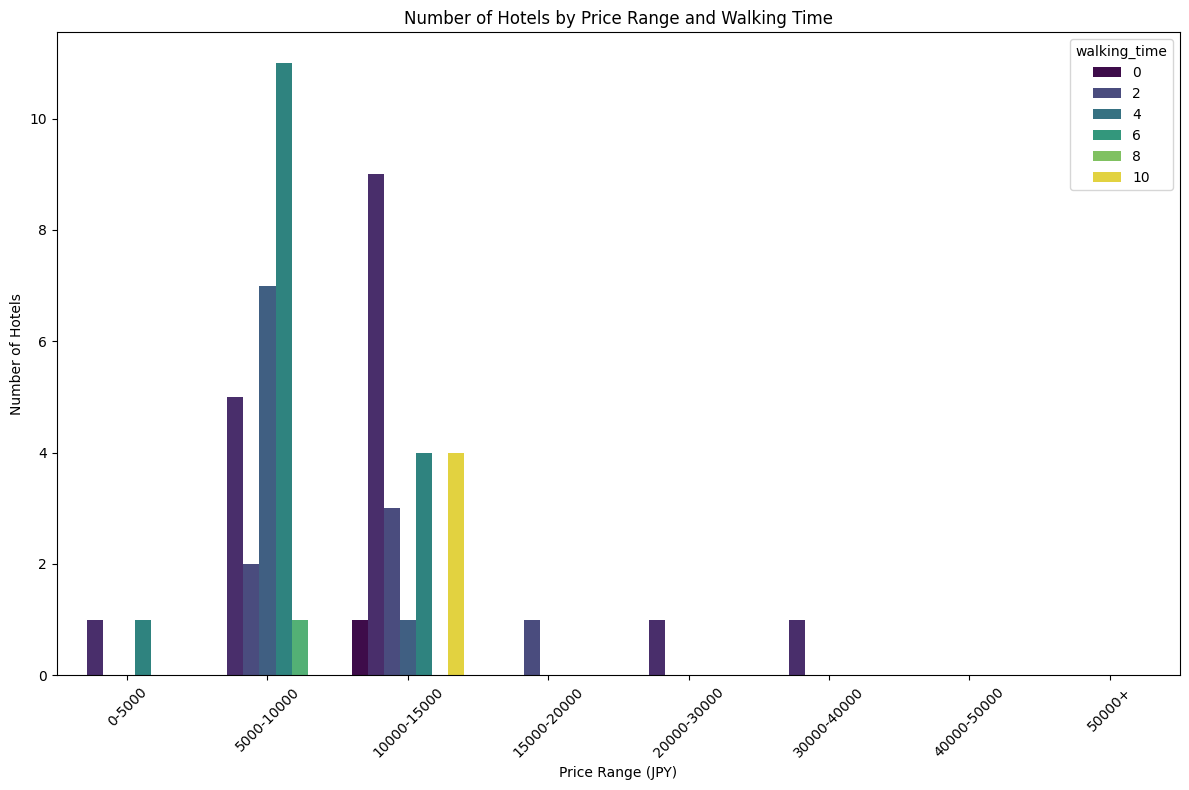

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

#徒歩時間と価格帯とホテルの数の関係を可視化
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='price_range', hue='walking_time', order=labels, palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('Price Range (JPY)')
plt.ylabel('Number of Hotels')
plt.title('Number of Hotels by Price Range and Walking Time')
plt.tight_layout()

plt.show()


In [12]:
#徒歩時間と値段の相関関係を計算
correlation = df[['price', 'walking_time']].corr()
print(correlation)


                 price  walking_time
price         1.000000     -0.002794
walking_time -0.002794      1.000000


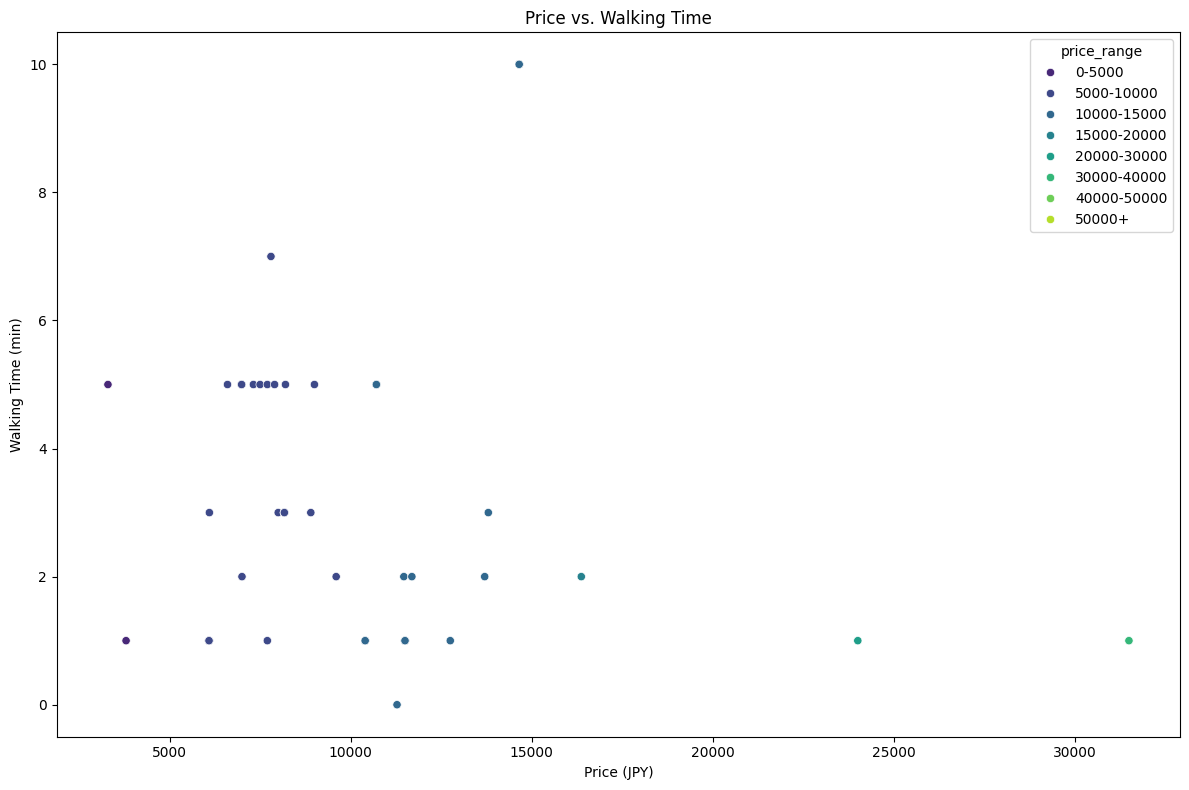

In [13]:
#徒歩時間と値段の相関関係を可視化
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='price', y='walking_time', hue='price_range', palette='viridis')
plt.xlabel('Price (JPY)')
plt.ylabel('Walking Time (min)')
plt.title('Price vs. Walking Time')
plt.tight_layout()

plt.show()

この結果を見ると、まず最寄り駅からホテルまで徒歩10分以上かかるホテルは存在せず、全てが駅から近いということがわかる。また、徒歩時間と値段にほぼ相関関係はないということもわかる。
相関関係がないということから、ホテルの値段は駅からのアクセスの良さではなく、部屋から見える景観や部屋のグレードに依存することが考察できる。

/var/folders/ln/0xp6fgr90hg1nt1431b5w7fc0000gn/T/ipykernel_13400/2389939753.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x='price', bins=bins, kde=True, palette='viridis')
/Users/kanaha/trip/.venv/lib/python3.12/site-packages/seaborn/distributions.py:474: RuntimeWarning: invalid value encountered in subtract
  edges = res[orient].to_numpy() - widths / 2


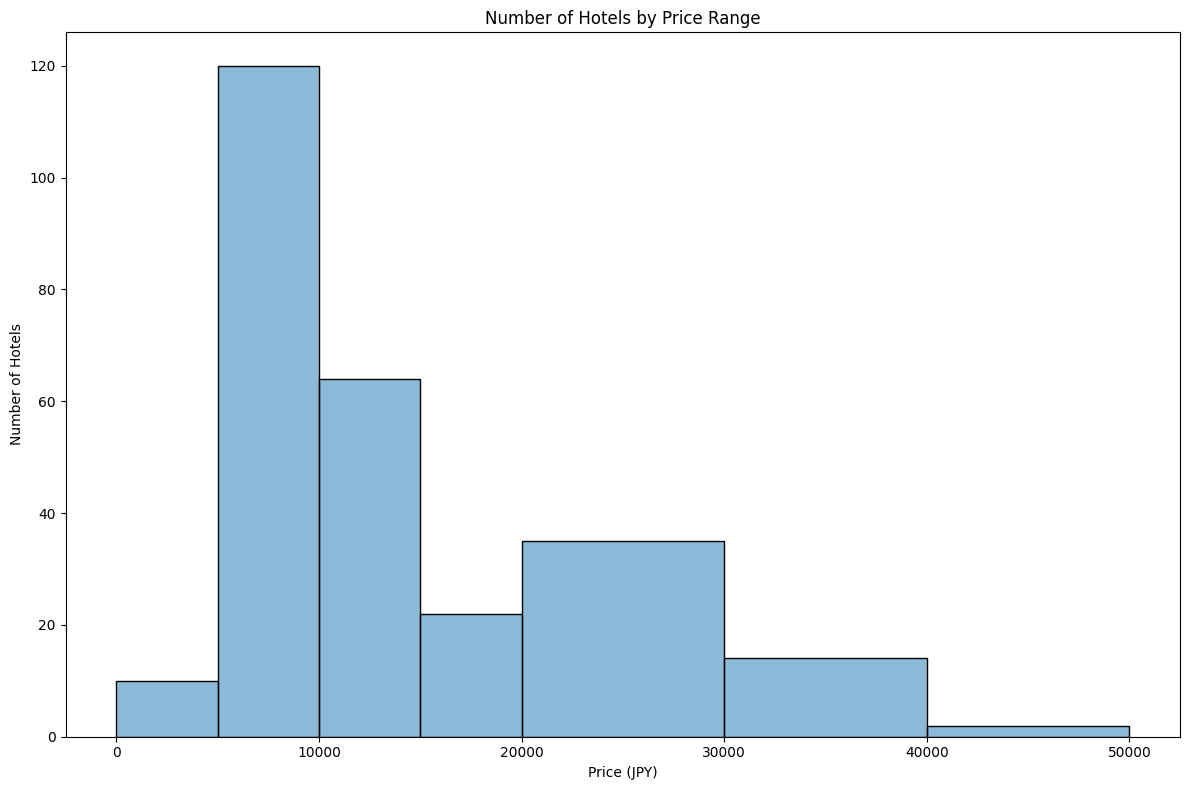

In [14]:
#価格帯ごとを可視化
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='price', bins=bins, kde=True, palette='viridis')
plt.xlabel('Price (JPY)')
plt.ylabel('Number of Hotels')
plt.title('Number of Hotels by Price Range')
plt.tight_layout()

plt.show()

上のグラフから一万円前後の価格帯が多いということがわかる。比較的リーズナブルに宿泊できるという点から、みなとみらいは若い世代や学生が多く利用するということが考察できる。

次に銀座にあるホテルを、みなとみらいと同様にスクレイピングした。
みなとみらいは学生などの若い世代が多く利用すると考察したため、裕福な大人が利用するイメージのある銀座を対象とし比較することを目的とする。

In [21]:
# 必要なモジュールをインポートする
import sqlite3
import requests
from bs4 import BeautifulSoup
import re
import time
import chardet  # エンコーディング検出用

# データベースの初期化またはアップデート
def init_db():
    conn = sqlite3.connect("hotels_fixed.db")
    cursor = conn.cursor()
    
    # テーブルが存在しない場合は作成
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS hotel_info_fixed (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            hotel_name TEXT,
            price TEXT,
            walking_time TEXT
        )
    """)
    conn.commit()
    conn.close()

# データを挿入
def insert_data(hotel_name, price, walking_time):
    conn = sqlite3.connect("hotels_fixed.db")
    cursor = conn.cursor()
    cursor.execute("INSERT INTO hotel_info_fixed (hotel_name, price, walking_time) VALUES (?, ?, ?)", (hotel_name, price, walking_time))
    conn.commit()
    conn.close()

# 駅から徒歩時間を抽出する関数
def extract_walking_time(catch_phrase):
    match = re.search(r"徒歩(\d+)分", catch_phrase)
    if match:
        return f"{match.group(1)}分"
    else:
        return "情報なし"

# 指定したURLからスクレイピング
def scrape_url(url):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        # レスポンスのエンコーディングを自動検出
        detected_encoding = chardet.detect(response.content)["encoding"]

        # BeautifulSoupにエンコーディングを明示
        soup = BeautifulSoup(response.content, "html.parser", from_encoding=detected_encoding)
        hotel_items = soup.find_all("li", class_="p-yadoCassette p-searchResultItem")

        for item in hotel_items:
            try:
                # ホテル名
                hotel_name = item.find("h2", class_="p-searchResultItem__facilityName").text.strip()

                # 値段
                price = item.find("span", class_="p-searchResultItem__perPersonPrice").text.strip()

                # 徒歩時間をキャッチフレーズから抽出
                catch_phrase_tag = item.find("p", class_="p-searchResultItem__catchPhrase")
                if catch_phrase_tag:
                    catch_phrase = catch_phrase_tag.text.strip()
                    walking_time = extract_walking_time(catch_phrase)
                else:
                    walking_time = "情報なし"

                # デバッグ用ログ
                print(f"ホテル名: {hotel_name}, 値段: {price}, 徒歩時間: {walking_time}")

                # データベースに挿入
                insert_data(hotel_name, price, walking_time)

                # サーバー負荷を避けるためのスリープ
                time.sleep(1)
            except AttributeError:
                # 必要な要素が見つからない場合にスキップ
                continue
    else:
        print(f"Failed to fetch the page. Status code: {response.status_code}")

# メイン処理
if __name__ == "__main__":
    init_db()  # データベースの初期化またはアップデート

    # スクレイピングするURLリスト
    urls = [
        "https://www.jalan.net/uw/uwp2011/uww2011search.do?actionId=G&keyword=%8B%E2%8D%C0&dateUndecided=1&stayYear=2025&stayMonth=01&stayDay=19&adultNum=1&minPrice=0&maxPrice=999999&distCd=06&rootCd=7701&dispStartIndex=30&activeSort=0&screenId=UWW2011",
        "https://www.jalan.net/uw/uwp2011/uww2011search.do?actionId=G&keyword=%8B%E2%8D%C0&dateUndecided=1&stayYear=2025&stayMonth=01&stayDay=19&adultNum=1&minPrice=0&maxPrice=999999&distCd=06&rootCd=7701&dispStartIndex=0&activeSort=0&screenId=UWW2011",
        "https://www.jalan.net/uw/uwp2011/uww2011search.do?actionId=G&keyword=%8B%E2%8D%C0&dateUndecided=1&stayYear=2025&stayMonth=01&stayDay=19&adultNum=1&minPrice=0&maxPrice=999999&distCd=06&rootCd=7701&dispStartIndex=60&activeSort=0&screenId=UWW2011",
        "https://www.jalan.net/uw/uwp2011/uww2011search.do?actionId=G&keyword=%8B%E2%8D%C0&dateUndecided=1&stayYear=2025&stayMonth=01&stayDay=19&adultNum=1&minPrice=0&maxPrice=999999&distCd=06&rootCd=7701&dispStartIndex=90&activeSort=0&screenId=UWW2011"
    ]

    # 各URLを順にスクレイピング
    for url in urls:
        scrape_url(url)

ホテル名: スーパーホテル東京・日本橋三越前, 値段: 17,600円, 徒歩時間: 情報なし
ホテル名: トーセイホテル ココネ築地銀座プレミア, 値段: 24,400円, 徒歩時間: 情報なし
ホテル名: スーパーホテルPremier銀座　天然温泉　奥湯河原の湯, 値段: 18,500円, 徒歩時間: 情報なし
ホテル名: 三井ガーデンホテル銀座プレミア, 値段: 40,500円, 徒歩時間: 5分
ホテル名: ホテルグランバッハ東京銀座, 値段: 60,500円, 徒歩時間: 情報なし
ホテル名: the b 銀座, 値段: 26,000円, 徒歩時間: 情報なし
ホテル名: ソラリア西鉄ホテル銀座, 値段: 23,500円, 徒歩時間: 情報なし
ホテル名: スマイルホテル東京日本橋, 値段: 16,800円, 徒歩時間: 情報なし
ホテル名: 三井ガーデンホテル京橋, 値段: 41,000円, 徒歩時間: 5分
ホテル名: ＪＲ西日本グループ ヴィアイン秋葉原, 値段: 10,200円, 徒歩時間: 4分
ホテル名: アパホテル〈人形町駅北〉〈2024年11月客室設備リニューアル〉, 値段: 7,761円, 徒歩時間: 11分
ホテル名: ホテル グレイスリー銀座, 値段: 14,915円, 徒歩時間: 3分
ホテル名: グランドセントラルホテル, 値段: 8,900円, 徒歩時間: 3分
ホテル名: 銀座ベルビューホテル, 値段: 8,500円, 徒歩時間: 3分
ホテル名: レム日比谷, 値段: 23,750円, 徒歩時間: 情報なし
ホテル名: スーパーホテルPremier東京駅八重洲中央口　高濃度炭酸泉, 値段: 20,700円, 徒歩時間: 情報なし
ホテル名: 帝国ホテル 東京, 値段: 112,000円, 徒歩時間: 情報なし
ホテル名: Ｌ　ｓｔａｙ＆ｇｒｏｗ晴海, 値段: 9,800円, 徒歩時間: 3分
ホテル名: ロイヤルパークホテル, 値段: 32,400円, 徒歩時間: 情報なし
ホテル名: ダイワロイネットホテル東京京橋 PREMIER, 値段: 33,340円, 徒歩時間: 8分
ホテル名: ホテルリソル秋葉原, 値段: 18,500円, 徒歩時間: 情報なし
ホテル名: Ｊホテル東京ジオ, 値段: 49,500円, 徒歩時間

In [22]:
# import sqlite3

# データベースに接続
conn = sqlite3.connect('hotels_fixed.db')

# カーソルを作成
cur = conn.cursor()

# SQLコマンドを実行
cur.execute("SELECT * FROM hotel_info_fixed")

# 結果を取得して表示
results = cur.fetchall()
for row in results:
    print(row)

# 接続を閉じる
conn.close()

(1, 'スーパーホテル東京・日本橋三越前', '17,600円', '情報なし')
(2, 'トーセイホテル ココネ築地銀座プレミア', '24,400円', '情報なし')
(3, 'スーパーホテルPremier銀座\u3000天然温泉\u3000奥湯河原の湯', '18,500円', '情報なし')
(4, '三井ガーデンホテル銀座プレミア', '40,500円', '5分')
(5, 'ホテルグランバッハ東京銀座', '60,500円', '情報なし')
(6, 'the b 銀座', '26,000円', '情報なし')
(7, 'ソラリア西鉄ホテル銀座', '23,500円', '情報なし')
(8, 'スマイルホテル東京日本橋', '16,800円', '情報なし')
(9, '三井ガーデンホテル京橋', '41,000円', '5分')
(10, 'ＪＲ西日本グループ ヴィアイン秋葉原', '10,200円', '4分')
(11, 'アパホテル〈人形町駅北〉〈2024年11月客室設備リニューアル〉', '7,761円', '11分')
(12, 'ホテル グレイスリー銀座', '14,915円', '3分')
(13, 'グランドセントラルホテル', '8,900円', '3分')
(14, '銀座ベルビューホテル', '8,500円', '3分')
(15, 'レム日比谷', '23,750円', '情報なし')
(16, 'スーパーホテルPremier東京駅八重洲中央口\u3000高濃度炭酸泉', '20,700円', '情報なし')
(17, '帝国ホテル 東京', '112,000円', '情報なし')
(18, 'Ｌ\u3000ｓｔａｙ＆ｇｒｏｗ晴海', '9,800円', '3分')
(19, 'ロイヤルパークホテル', '32,400円', '情報なし')
(20, 'ダイワロイネットホテル東京京橋 PREMIER', '33,340円', '8分')
(21, 'ホテルリソル秋葉原', '18,500円', '情報なし')
(22, 'Ｊホテル東京ジオ', '49,500円', '6分')
(23, '京急ＥＸイン東銀座', '14,960円', '3分')
(24, 'ダイワロイネットホテル銀座 PREMIER', '32,500

In [23]:
# import sqlite3
# import pandas as pd
# import re

class DatabaseAnalyzer:
    def __init__(self, dbname):
        self.dbname = dbname

    def get_data(self, query):
        # データベースに接続
        conn = sqlite3.connect(self.dbname)

        # SQLクエリを発行してデータをPandasのデータフレームに読み込む
        df = pd.read_sql_query(query, conn)

        # 接続を閉じる
        conn.close()

        return df

    def clean_price_column(self, df):
        #正規表現を用いて徒歩時間から数値のみを抽出
        df['walking_time'] = df['walking_time'].apply(lambda x: int(re.search(r'\d+', x).group()) if re.search(r'\d+', x) else None)
        # 正規表現を用いて価格列から数値のみを抽出
        df['price'] = df['price'].apply(lambda x: int(re.search(r'\d+', x.replace(',', '')).group()) if re.search(r'\d+', x) else None)
        return df

    def analyze_price(self, df):
        # クレンジングされたデータを使用して統計量を出力
        if df['price'].isnull().any():
            print("一部のデータに無効な価格情報が含まれていましたが、それらを除外して処理しました。")

        # 基本統計量を表示
        print(df['price'].describe())


# データベースアナライザーのインスタンスを作成
analyzer = DatabaseAnalyzer('hotels_fixed.db')

# データを取得
data = analyzer.get_data("SELECT * FROM hotel_info_fixed")

# 価格列をクレンジング
data = analyzer.clean_price_column(data)

# 価格データを分析
analyzer.analyze_price(data)


count       136.000000
mean      25904.176471
std       19973.468469
min        6800.000000
25%       12265.000000
50%       18660.000000
75%       34185.000000
max      112000.000000
Name: price, dtype: float64


In [24]:
#dfを定義する
df = data
# 価格帯を定義
bins = [0, 5000, 10000, 15000, 20000, 30000, 40000, 50000, float('inf')]
labels = ['0-5000', '5000-10000', '10000-15000', '15000-20000', '20000-30000', '30000-40000', '40000-50000', '50000+']

# 価格帯に基づいて新しい列を作成
df['price2_range'] = pd.cut(df['price'], bins=bins, labels=labels)


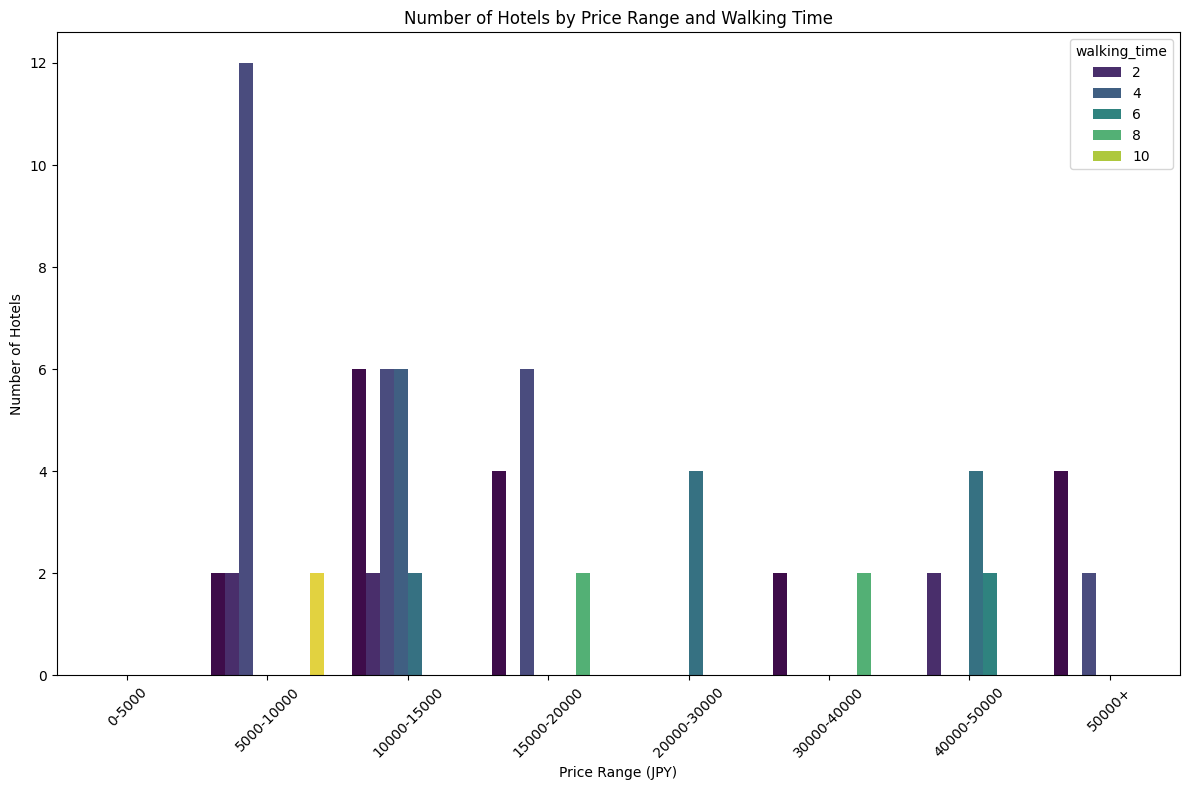

In [25]:
#徒歩時間と価格帯とホテルの数の関係を可視化
plt.figure(figsize=(12, 8))
sns.countplot(data=data, x='price2_range', hue='walking_time', order=labels, palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('Price Range (JPY)')
plt.ylabel('Number of Hotels')
plt.title('Number of Hotels by Price Range and Walking Time')
plt.tight_layout()

plt.show()

/var/folders/ln/0xp6fgr90hg1nt1431b5w7fc0000gn/T/ipykernel_13400/2389939753.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x='price', bins=bins, kde=True, palette='viridis')
/Users/kanaha/trip/.venv/lib/python3.12/site-packages/seaborn/distributions.py:474: RuntimeWarning: invalid value encountered in subtract
  edges = res[orient].to_numpy() - widths / 2


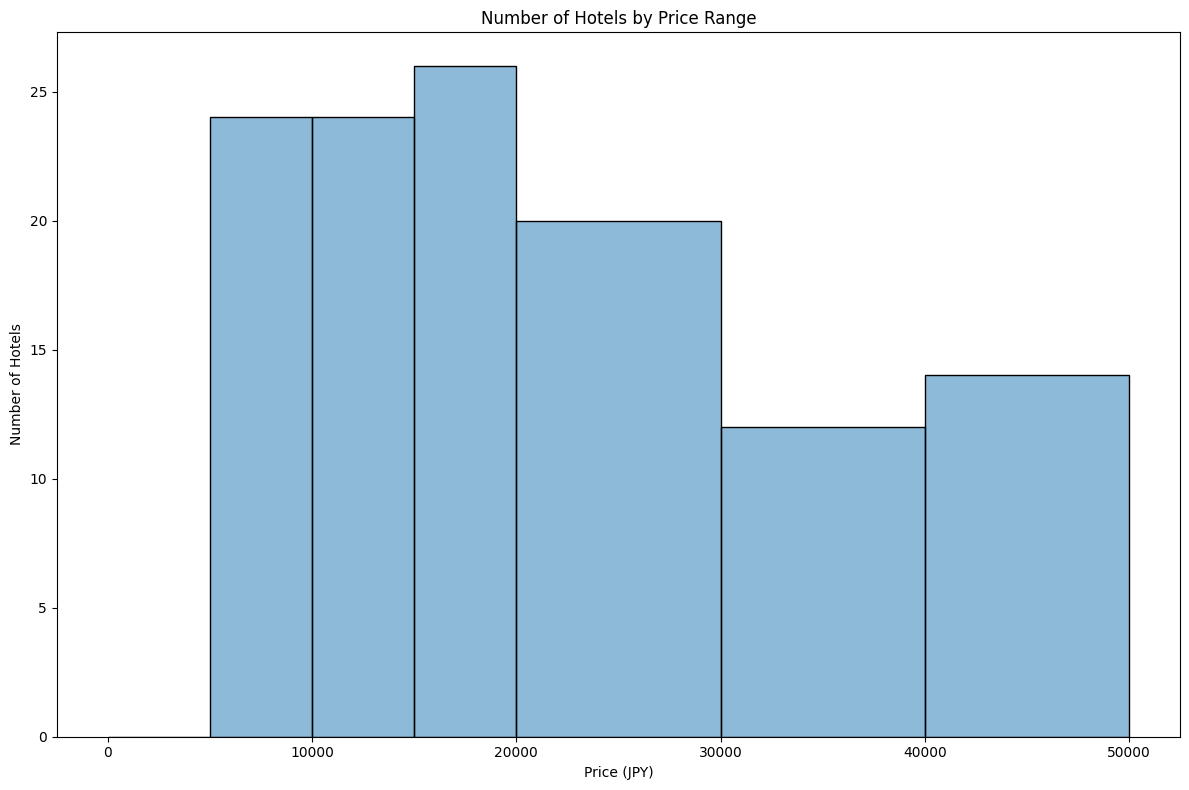

In [26]:
#価格帯ごとを可視化
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='price', bins=bins, kde=True, palette='viridis')
plt.xlabel('Price (JPY)')
plt.ylabel('Number of Hotels')
plt.title('Number of Hotels by Price Range')
plt.tight_layout()

plt.show()

みなとみらいと比較すると、明らかに価格帯が広いということがわかる。しかし、みなとみらいと同様に最も多い価格帯は一万円前後である。銀座は裕福な人が利用するため高価なホテルが多いと予想していたが、それは間違いのようだ。ショッピングを楽しむためにあえてホテルのレベルを下げていたり、都内での仕事のために出張できているビジネスマンなどがいたりするのだろうと考察できる。